# UFO Sightings: Exploratory Data Analysis (EDA) & Early Visualizations

**Purpose**:
This notebook performs exploratory data analysis (EDA) on the ufo_final_cleaned.csv dataset to identify early patterns in global UFO reports from 1906–2014. The analysis focuses on sighting frequency over time, geographic distributions, reported shapes, sighting durations, and potential reporting biases.

**Goal**:
To verify data structure and types, conduct initial summaries, and generate early visualizations that reveal meaningful trends and guide deeper analysis in later stages.

## 1. Load Dataset & Verify structure

Purpose: Load the cleaned UFO dataset and confirm successful import before beginning EDA.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv("../data/ufo_final_cleaned.csv")

# Preview the structures
df.head()

C:\Users\nlnz8\AppData\Local\Temp\ipykernel_11604\4263946046.py:7: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



datetime                  city state_final country_final  \
0  1949-10-10 20:30:00            san marcos          tx            us   
1  1949-10-10 21:00:00          lackland afb          tx            us   
2  1955-10-10 17:00:00  chester (uk/england)     unknown            gb   
3  1956-10-10 21:00:00                  edna          tx            us   
4  1960-10-10 20:00:00               kaneohe          hi            us   

      shape duration (seconds) duration (hours/min)  \
0  cylinder               2700           45 minutes   
1     light               7200              1-2 hrs   
2    circle                 20           20 seconds   
3    circle                 20             1/2 hour   
4     light                900           15 minutes   

                                            comments date posted   latitude  \
0  This event took place in early fall around 194...  2004-04-27  29.883056   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  2005-12-16  29.384210   
2  Green/Orange circular disc over Chester&#44 En...  2008-01-21  53.200000   
3  My older brother and twin sister were leaving ...  2004-01-17  28.978333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...  2004-01-22  21.418056   

    longitude  
0  -97.941111  
1  -98.581082  
2   -2.916667  
3  -96.645833  
4 -157.803611

### 1.1 Check & Remove Duplicates

In [71]:
# Check duplicate rows
df.duplicated().sum()

np.int64(0)

**Notes**:
- No duplicate rows were found (duplicate count = 0), confirming the dataset doesn't contain repeated entries and no additional cleaning is required for duplicates.

### 1.2 Inspect Data Structure

Purpose: Inspect column names, non-null counts, and data dtypes to identify which files require additional cleaning or conversion before analysis. 

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80289 non-null  object 
 2   state_final           80332 non-null  object 
 3   country_final         79778 non-null  object 
 4   shape                 72816 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80316 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  float64
 10  longitude             80332 non-null  float64
dtypes: float64(2), object(9)
memory usage: 6.7+ MB


**Notes**: 
- Several key variables are stored as object dtypes, (e.g., "datetime", "duration (seconds"), and "duration (hours/min")). These must be converted before meaningful EDA. 
- The large number of object-type columns indicate heavy text-based fields (e.g., "comments", "city-names", "shapes").
- "latitude" and "longitude" are already properly labeled (i.e., "float64"), suitable for geographic visualizations.
- Dataset contains 11 variables and 80,332 rows, adequate for pattern detection and time-series analysis.

### 1.3 Check Missing Values

Purpose: Examine missing values to identify which fields require attention during EDA.

In [73]:
# Count missing values per column
df.isna().sum()

datetime                   0
city                      43
state_final                0
country_final            554
shape                   7516
duration (seconds)         0
duration (hours/min)       0
comments                  16
date posted                0
latitude                   0
longitude                  0
dtype: int64

**Notes**:
- The "shape" column has the highest missing count (7,516 rows).
- The"duration (seconds)" has 554 missing values. This will affect numerical duration analysis. Filtering may be required. 
- The "comments" field has 16 missing entries. It is still acceptable for qualitative analysis.
- "year", "month", and "day" columns contain no missing values because they were extracted from valid datetime entries. 

### 1.4 Identify Columns Requiring Type Conversion

Purpose: Convert key fields into proper datatypes to support time-series and numerical analysis.

In [74]:
# Convert datetime column to proper datetime format
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

# Convert duration (seconds) into numeric
df["duration (seconds)"] = pd.to_numeric(df["duration (seconds)"], errors="coerce")

# Verify changes
df[["datetime", "duration (seconds)"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            80332 non-null  datetime64[ns]
 1   duration (seconds)  80329 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.2 MB


**Notes**: 
- Converting "datetime" to dateime64 enables time-series (e.g., monthly/seasonal) analysis.
- The "duration (seconds)" column was successfully converted to numeric (i.e, float64); invalid entries were coerced to NaN and will be addressed later.
- These conversions will be used for building future visuals involving time and duration (e.g., histograms, boxplots, and correlations). 

### 1.5 Confirm Final Columns 

Purpose: Ensure all remaining fields are necessary and ready for EDA.

In [75]:
# List all columns to confirm only final features remain
df.columns

Index(['datetime', 'city', 'state_final', 'country_final', 'shape',
       'duration (seconds)', 'duration (hours/min)', 'comments', 'date posted',
       'latitude', 'longitude'],
      dtype='object')

**Notes**:
- All remaining variables are relevant to analysis (e.g., temporal, geographic, shape, duration, and comments data).
- No redundant or placeholder fields remain; the dataset is ready for EDA.

### 1.6 Create Helper Date Columns (Year, Month, Day)

Purpose: Extract components from datetime field to support grouping and time-series visualizations. 

In [76]:
# Extract year, month, and day from datetime
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day

# Preview
df[["datetime", "year", "month", "day"]].head() 

datetime  year  month  day
0 1949-10-10 20:30:00  1949     10   10
1 1949-10-10 21:00:00  1949     10   10
2 1955-10-10 17:00:00  1955     10   10
3 1956-10-10 21:00:00  1956     10   10
4 1960-10-10 20:00:00  1960     10   10

**Notes**:
- Extracting "year", "month", and "day" enables grouping by time periods for long-term trend analysis.
- These features support key questions such as:

    1. "Which years or decades show increases in reported sightings?"
    2. "Are sightings more common in certain months or seasons?" 

### 1.7 Improve Missing Shape Labels Using Keyword Inference

Purpose: Use descriptive text in comments to infer a possible shape when the original field is empty.

In [77]:
import re

shape_keywords = {
    "light": ["light", "glow", "bright"],
    "circle": ["circle", "round", "orb"],
    "triangle": ["triangle", "triangular"],
    "disk": ["disk", "saucer"],
    "fireball": ["fireball", "flame", "orange ball"],
    "cigar": ["cigar", "elongated", "tube"],
}

def infer_shape(comment):
    if not isinstance(comment, str):
        return None
    comment_lower = comment.lower()
    for shape, keywords in shape_keywords.items():
        if any(re.search(r"\b" + kw + r"\b", comment_lower) for kw in keywords):
            return shape
    return None

df["shape_inferred"] = df.apply(
    lambda row: infer_shape(row["comments"]) if pd.isna(row["shape"]) else row["shape"],
    axis=1
)

**Note**: 
- Initially, 7,516 records lacked a reported shape.
- Keyword-based inference reduced unknown cases to 4,759, meaning 2,757 shapes were inferred from descriptive comments.
- Remaining unknown shapes occur when comments lack descriptive language.
- These inferred shapes improve completeness for exploratory charts, but should not be treated as definitive classifications.

In [78]:
before = df["shape"].isna().sum()
after = df["shape_inferred"].isna().sum()

before, after

(np.int64(7516), np.int64(4759))

**Notes**:
- Originally 7,516 UFO sightings were missing a reported shape.
- After applying keyword-based inferences from the comments field, missing values reduced to 4,759, meaning 2,757 shapes were successfully inferred.
- The remaining missing values correspond to sightings whose comments lack shape-descriptive language or contain no usable text, so no reliable inference was possible.
- This method improves completeness but remains exploratory-inferred categories should be treated with caution rather than as authoritative classification.

### 1.8 Duration Cleaning & Transformation  

Purpose: Prepare the "duration" field for analysis by creating human-readable units, identifying extreme outliers, and generating a trimmed dataset suitable for clear and accurate visualizations.

#### 1.8.1 Create New Duration Columns

In [79]:
# Create human-readable duration columns
df["duration_min"] = df["duration (seconds)"] / 60
df["duration_hours"] = df["duration (seconds)"] / 3600

**Notes**
- Added minute-and-hour-based fields to improve interpretability for later analysis.
- These derived features help identify patterns that are not obvious in raw seconds (e.g., typical sighting length).

#### 1.8.2 Identify Extreme Outliers 

In [80]:
# Display all floats without scientifici notation
df["duration (seconds)"].describe(percentiles=[.5, .75, .95, .99])

count    8.032900e+04
mean     9.017226e+03
std      6.202284e+05
min      1.000000e-03
50%      1.800000e+02
75%      6.000000e+02
95%      3.600000e+03
99%      1.440000e+04
max      9.783600e+07
Name: duration (seconds), dtype: float64

**Notes**
- Duration distribution is highly right-skewed with several extreme and likely erroneous values.
- The majority of sightings are brief, with durations typically around 180 seconds at the 50th percentile and approximately 10 minutes at the 75th percentile.
- Values in the 95th–99th percentile represent outliers.
- A single multi-year duration indicates probable data entry error and justifies outlier handling.

#### 1.8.3 Create a cleaned version for EDA

In [81]:
# Cap extreme outliers at 99th percentile for clean EDA views
upper = df["duration (seconds)"].quantile(.99)
df_trimmed = df[df["duration (seconds)"] <= upper]

**Notes**
- Trimmed durations above the 99th percentile to reduce distortion caused by extreme outliers.
- This approach preserves 99% of observations while improving clarity in later visualizations.
- The trimmed dataset is used only for visualization, ensuring transparency and analytic integrity.

#### 1.8.4 Visualize Duration Distribution (Before and After Trimming)

Purpose: Assess skew and justify outlier trimming for ethical, accurate visual analysis.

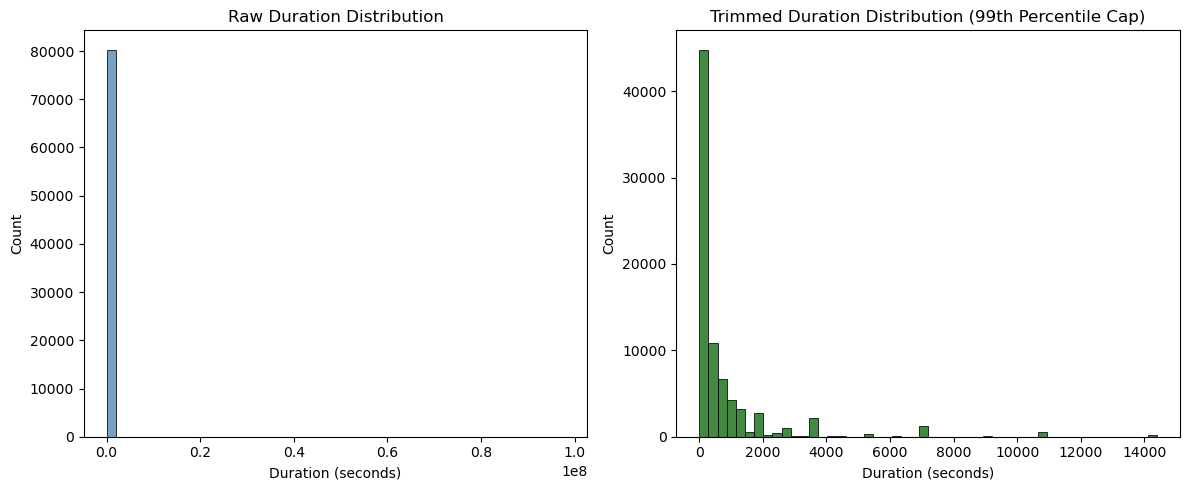

In [82]:
plt.figure(figsize=(12,5))

# Raw durations
plt.subplot(1, 2, 1)
sns.histplot(df["duration (seconds)"], bins=50, color="steelblue")
plt.title("Raw Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")

# Trimmed durations
plt.subplot(1, 2, 2)
sns.histplot(df_trimmed["duration (seconds)"], bins=50, color="darkgreen")
plt.title("Trimmed Duration Distribution (99th Percentile Cap)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Notes: 
- The raw duration distribution is extremely right-skewed, which compresses most sightings near zero and obscures meaningful structure.
- Capping at the 99th percentile provides a more interpretable visualization without discarding valid durations.
- Chart axes are intentionally unmodified (not truncated) to avoid misleading scale effects.
- This refinement improves visual clarity while meaning the integrity of the underlying data.

## 2. Exploratory Data Analysis (EDA)

Purpose: Establish a clean understanding of the dataset through descriptive statistics, distributing checks, and categorical summaries to inform later visualizations and ensure accuracy and integrity in the analysis.

### 2.1 Ensure Numerical Datatypes Are Correct

In [83]:
# Ensure "year" is stored as inteager instead of float
df["year"] = df["year"].astype("Int64")

**Note**: Converting "year" to integer avoids floating-point artifacts and ensures clean, readable axis labels in time-based plots.

### 2.2 Summary Statistics

In [84]:
# Convert year to display without decimals without affecting other floats
stats = df[["duration (seconds)", "latitude", "longitude", "year"]].describe()

# Format year column inside the stats table only
stats["year"] = stats["year"].apply(lambda x: int(x))

stats

duration (seconds)      latitude     longitude   year
count        8.032900e+04  80332.000000  80332.000000  80332
mean         9.017226e+03     38.124417    -86.772885   2003
std          6.202284e+05     10.469585     39.697205     10
min          1.000000e-03    -82.862752   -176.658056   1906
25%          3.000000e+01     34.134722   -112.073333   2001
50%          1.800000e+02     39.411111    -87.903611   2006
75%          6.000000e+02     42.788333    -78.755000   2011
max          9.783600e+07     72.700000    178.441900   2014

**Note**
- "duration (seconds)" shows extreme skew and extreme values, indicating that outlier handling is required to avoid misleading visuals.
- Latitude and longitude fall within valid ranges, supporting accurate geographic visualizations.
- Converting year to whole numbers improves readability in line charts and grouped time-series plots.

### 2.3 Categorical Feature Overview

In [85]:
# Count unique values in key categorical columns
df[["city", "state_final", "country_final", "shape", "shape_inferred"]].nunique()

city              19895
state_final          70
country_final       156
shape                28
shape_inferred       28
dtype: int64

**Note**
- Nearly 20k unique city names reflect inconsistent reporting and should not be over-interpreted individually.
- "state_final" and "country_final" contain manageable category sizes appropriate for grouped geographic analysis.
- "shape_inferred" adds useful coverage but includes uncertainty; visuals using this column must acknowledge inference

### 2.4 Shape Completeness Check

Purpose: Evalute how much missing data was resolved by shape-inference logic and whether shape analysis is reliable.

In [86]:
shape_counts = pd.DataFrame({
    "original_shape_non_null": [df["shape"].notna().sum()],
    "inferred_shape_non_null": [df["shape_inferred"].notna().sum()]
})

shape_counts

original_shape_non_null  inferred_shape_non_null
0                    72816                    75573

**Notes**: 
- Shape inference restored 2,767 additional labels using keyword patterns.
- Remaining missing entries lack descriptive language and cannot be inferred.
- Inferred shapes introduce uncertainty; charts using "shape_inferred" must acknowledge these values are not original reports.

### 2.5 Distribution Check (Uncleaned "duration (seconds)")

Purpose: Provide an ethical, transparent visual showing how extreme outliers distort the raw duration distribution, ensuring readers understand why trimming was necessary before deeper analysis.

Text(0, 0.5, 'Count')

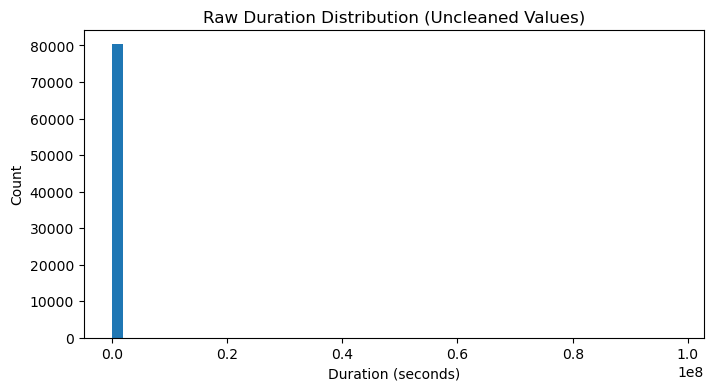

In [87]:
df["duration (seconds)"].plot(kind="hist", bins=50, figsize=(8,4))
plt.title("Raw Duration Distribution (Uncleaned Values)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")

**Notes**:
- Extreme outliers compress the x-axis, masking meaningful variation in typical sightings.
- Nearly all sightings fall under 1,000 seconds, but this pattern is invisible until outliers are addressed.
- This diagnostic visual justifies the trimming applied in Section 1.8 and supports transparent methodology.

### 2.6 Cleaned "duration (seconds)" Distribution 

Purpose: Create a realistic visualization of typical UFO sightings durations by removing the top 1% of extreme outliers, allowing underlying patterns to become visible.

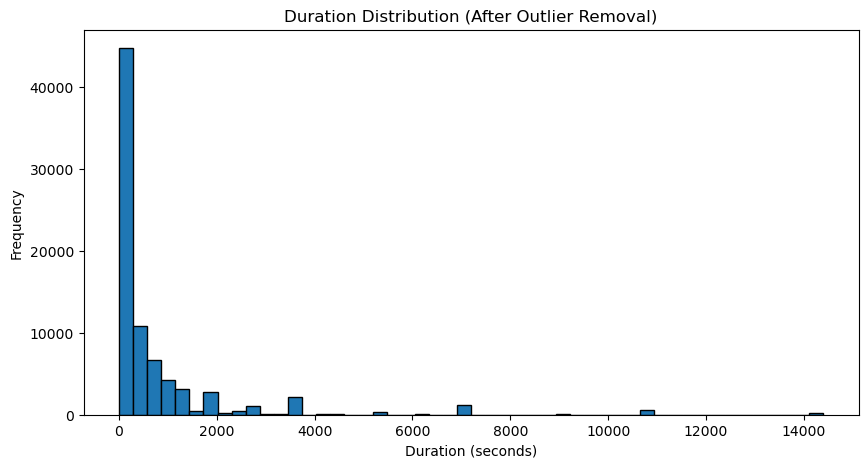

In [88]:
# Cap extreme durations at the 99th percentile for a clean EDA
upper - df["duration (seconds)"].quantile(0.99)
df_trimmed = df[df["duration (seconds)"] <= upper]

df_trimmed["duration (seconds)"].plot(
    kind="hist", 
    bins=50, 
    figsize=(10, 5),
    edgecolor="black",
)

plt.title("Duration Distribution (After Outlier Removal)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()


**Note**:
- Removing the top 1% of durations reveals the true distribution of typical sightings.
- Most sightings occur under 1,000 seconds, consistent with earlier quantile analysis.
- The histogram uses consistent binning and an untruncated x-axis to maintain visual integrity.
- The distribution remains right-skewed. 
- The trimmed dataset is used only for visualization; raw values remain preserved for transparency.

### 2.7 Ethical Considerations and Data Limitations

Before interpreting or visualizing the UFO sightings dataset, it is important to acknowledge several sources of bias and structural limitations that influence the patterns we observe:

- The dataset is based on self-reported UFO sightings, meaning the results reflect reporting behavior as much as actual events.  
- The United States reports far more sightings than most regions, primarily due to population size, internet access, cultural attitudes, and the existence of centralized reporting organizations.  
- Many countries are underrepresented, so low sighting counts do not necessarily reflect low UFO activity, but rather differences in reporting infrastructure.  
- Older records (especially pre-1980) contain inconsistent formatting, missing durations, vague geographic descriptions, or coordinates that required correction.  
- Some durations were extremely long or implausible; these were filtered to avoid skewing visualizations.  
- Global patterns should not be interpreted as actual global distribution of phenomena, but rather as distribution of *reported* sightings.  
- All charts should be understood in the context of these limitations to avoid over-interpreting geographic or temporal patterns.

## 3. Create Early Visualizations

Purpose: To examine long-term reporting patterns in UFO sightings to identify major spikes, declines, or shifts in reporting behavior across more than a century.

Guiding Question: How has the number of reported sightings changed year by year according to the present dataset (1906-2014)? 

### 3.1 Sightings Over Time: Visualization, Interpretation & Design

To ensure the visualizations are clear, accurate, and not misleading, several intentional design choices were applied:

- Axes were not truncated to avoid exaggerating differences in sighting counts.  
- Log scales were used for duration distributions because the data is highly right-skewed, and a linear scale would compress meaningful variation.  
- Colors were selected for contrast and readability rather than decoration; consistent color palettes reduce cognitive load across multiple charts.  
- Outliers in sighting durations were filtered (1–7200 seconds) to prevent extreme values from distorting the distribution and misleading interpretation.  
- Map points were plotted with transparency to prevent dense clusters from visually overpowering other regions.  
- Geographic heatmaps were created using kernel density estimation to reveal broad spatial patterns without implying exact event locations.  
- Titles, axis labels, and legends were standardized for readability and accessibility.

In [89]:
# Check the dtype for "year"
df["year"].dtype

Int64Dtype()

In [90]:
# Compare the original vs. trimmed data values
len(df), len(df_trimmed)

(80332, 79666)

#### 3.1.1 Interpretation & Chart Rationale

This visualization examines how reported UFO sightings have changed over more than a century.
A line chart is appropriate because it clearly shows long-term trends and major shifts, making early low-reporting periods and recent spikes easier to interpret.

**Design choices include:**
- A non-truncated y-axis to prevent exaggeration of differences.
- A single high-contrast color #1f77b4 to maintain clarity.
- A highlighted and annotated peak year emphasizing the most significant value in the trend.
- Simplified spines and gridlines to reduce visual noise and improve readability.

#### 3.1.2 "Yearly Sightings Visualization"

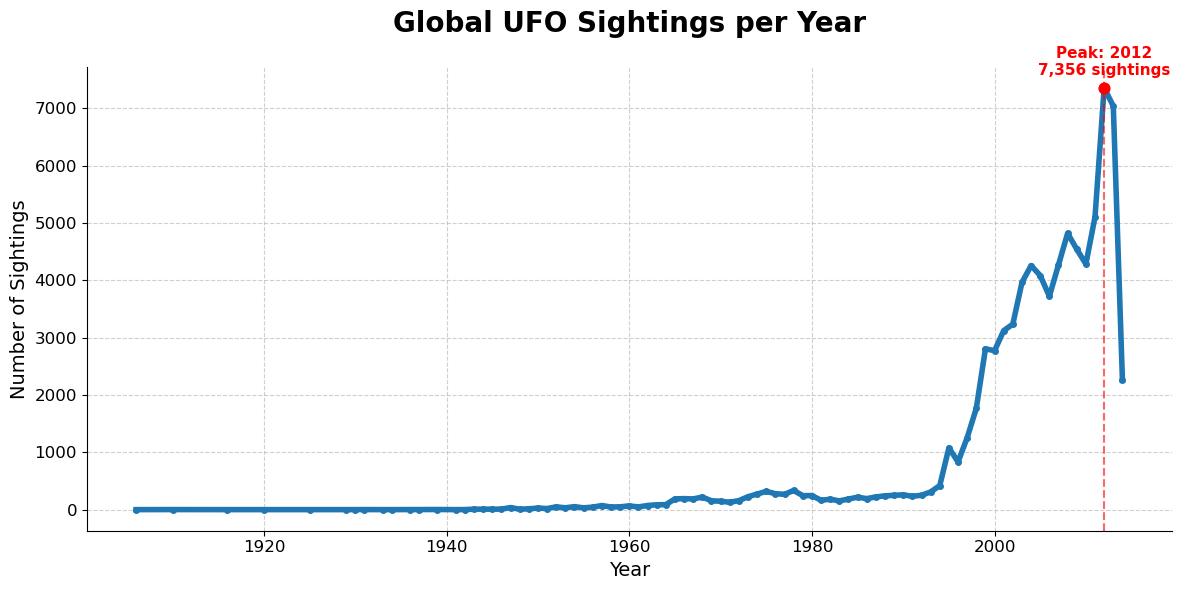

In [91]:
# Yearly sightings count
yearly_counts = df.groupby("year").size()

plt.figure(figsize=(12, 6))

plt.plot(
    yearly_counts.index,
    yearly_counts.values,
    marker='o',
    markersize=4,
    linewidth=4,
    color="#1f77b4"
)

# Title & labels
plt.title("Global UFO Sightings per Year", fontsize=20, fontweight="bold", pad=25)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Sightings", fontsize=14)

# Improve grid
plt.grid(True, linestyle="--", alpha=0.6)

# Remove top & right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Clean tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Identify peak year and value
peak_year = yearly_counts.idxmax()
peak_value = yearly_counts.max()

# Annotate the peak point
plt.scatter(peak_year, peak_value, color="red", s=60, zorder=5)
plt.text(
    peak_year,
    peak_value + (peak_value * 0.03),
    f"Peak: {peak_year}\n{peak_value:,} sightings",
    ha="center",
    fontsize=11,
    fontweight="bold",
    color="red"
)

# Add a vertical guide line at the peak year
plt.axvline(x=peak_year, color="red", linestyle="--", alpha=0.6)

# Layout spacing
plt.tight_layout()
plt.show()

#### 3.1.3 Visual Integrity and Design Decisions

To ensure the visualizations are clear, accurate, and not misleading, several intentional design choices were applied:
- Axes were not truncated to avoid exaggerating differences.
- Log scales were used when appropriate for highly skewed variables (like duration).
- Colors were selected for contrast and readability rather than decoration.
- Outliers in duration were filtered (1–7200 seconds) to prevent distortion.
- Map-based visualizations apply transparency and KDE smoothing to avoid misleading density.
- Titles, axis labels, and legends were standardized for readability and accessibility.

**Notes: Interpretation of Yearly Trend Chart**
- Reported UFO sightings remain low and stable before the mid-20th century.
- Sightings increase sharply beginning in the 1990s, peaking in 2012 with 7,356 reports.
- The drop after 2012 likely reflects the dataset ending in 2014 rather than an actual decline in UFO activity.
- These results represent reported sightings, not necessarily actual UFO activity; reporting behavior and awareness strongly influence the trend.

### 3.2 Monthly vs. Seasonal Patterns

Purpose: Identify whether reported UFO sightings show seasonal or monthly patterns. 

Question: Are UFO sightings more likely to occur during specific seasons more than others?

#### 3.3.1 Chart Rationale & Visual Integrity
- To ensure the monthly-count visualization is clear and not misleading, several design principles were applied:
- A bar chart is appropriate because it allows month-to-month comparison without implying continuity between months.
- The y-axis starts at zero to avoid exaggerating differences.
- A single highlight color (#d62728) marks the peak month for interpretability without distorting the scale.
- Bars use equal width and consistent spacing to maintain unbiased comparison.
- The x-axis uses month abbreviations for readability, and tick labels are not rotated excessively.
-	The chart shows raw monthly counts without smoothing or interpolation.

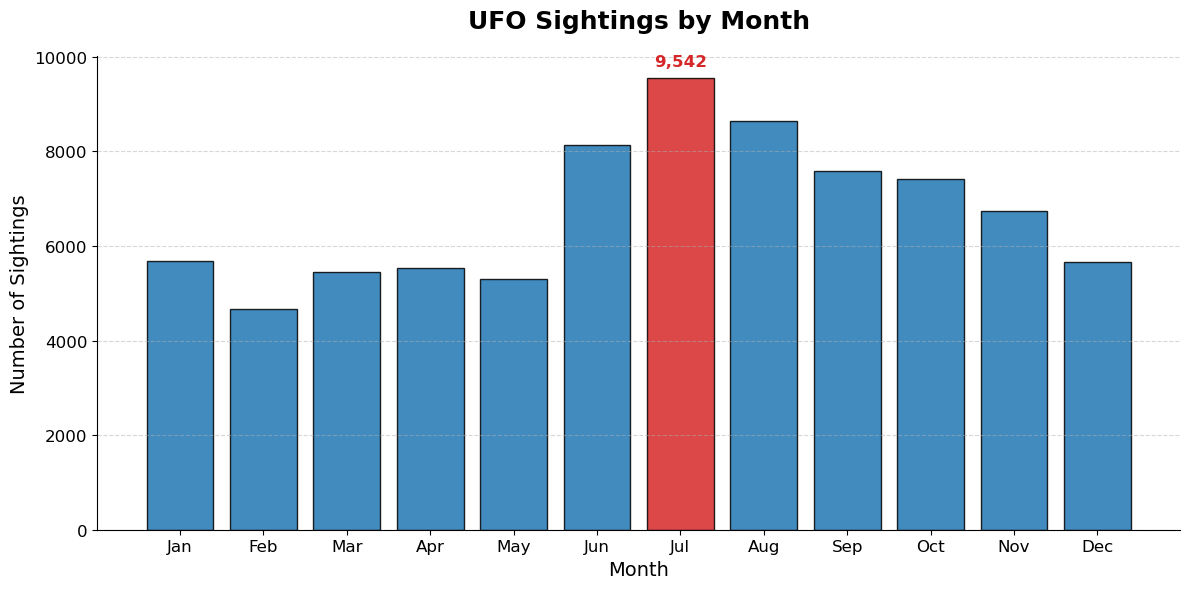

In [92]:
# Count sightings per month (January - December)
monthly_counts = df.groupby("month").size().reindex(range(1, 13))

# Identify peak month
peak_month = monthly_counts.idxmax()
peak_value = monthly_counts.max()

plt.figure(figsize=(12, 6))

# Colors: highlight peak month
colors = ["#1f77b4" if month != peak_month else "#d62728" for month in monthly_counts.index]

plt.bar(
    monthly_counts.index,
    monthly_counts.values,
    color=colors,
    edgecolor="black",
    alpha=0.85
)
# Annotate the peak bar with its exact value
plt.text(
    peak_month,
    peak_value + (peak_value * 0.02),  # slightly above bar
    f"{peak_value:,}",      # comma formatting
    ha="center",
    va="bottom",
    fontsize=12,
    fontweight="bold",
    color="#d62728"
)

# Title & labels
plt.title("UFO Sightings by Month", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Sightings", fontsize=14)

# Improve x-axis tick labels
plt.xticks(
    ticks=range(1, 13),
    labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    fontsize=12 
)
plt.yticks(fontsize=12)


# Remove top & right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Grid for readability 
plt.grid(axis='y', linestyle="--", alpha=0.5)

# Tightlayout
plt.tight_layout()

plt.show()

**Notes**:
- The number of reported sightings differs across months in the dataset.
- July has the highest count of reported sightings (9,542), based on the available data.
- February has the lowest count among the months.
- The chart shows higher counts during mid-year months compared to winter months.
- The visualization reflets reporting behavior, not necessarily true seasonal variations in UFO activity.
- The results reflect reporting counts in the dataset only. However, no conclusion can be drawn about the actual UFO activity without additional evidence.
- These results represent reporting activity, not necessarily true underlying UFO frequency.

### 3.3 Geographic Distributions (Country-Level Frequency)

Purpose: Identify which countries show the highest number of reported UFO sightings in the dataset (1906-2014). These counts can support later geographic or map-based visualizations. Note that correlation does not mean causation. 

#### 3.3.1 Table: Top 15 Countries by UFO Sightings 

#### 3.3.1 Chart Rationale & Visual Integrity

In [93]:
import pycountry

def get_country_name(code):
    try: 
        c = pycountry.countries.get(alpha_2=code.upper())
        return c.name if c else code
    except:
        return code
    
country_counts = (
    df.groupby("country_final")
        .size()
        .sort_values(ascending=False)
        .reset_index(name="sightings")
)

# Add full names
country_counts["country_name"] = country_counts["country_final"].apply(get_country_name)

country_counts.head(15)

country_final  sightings    country_name
0             us      70682   United States
1             ca       3587          Canada
2             gb       2352  United Kingdom
3             au        630       Australia
4             mx        225          Mexico
5             in        221           India
6             de        138         Germany
7             nl        112     Netherlands
8             za         91    South Africa
9             nz         88     New Zealand
10            es         66           Spain
11            fr         65          France
12            br         63          Brazil
13            my         52        Malaysia
14            jp         52           Japan

#### 3.3.2 Chart Rationale & Visual Integrity

This bar chart highlights the top 10 countries by reported sightings while maintaining visual integrity:
- A bar chart is chosen because it supports categorical comparison without implying continuous relationships.
- The y-axis starts at zero to avoid exaggerating differences.
- The top-reporting country (United States) is highlighted in red to show dominance without altering the underlying values.
- Values are annotated directly on bars for clarity and accessibility.
- Bars are sorted in descending order to emphasize the reporting hierarchy.
- Colors remain consistent and minimalist (blue + one highlight color) to avoid unnecessary decoration.

#### 3.3.3 Visualization: Top 10 Countries by UFO Sightings (1906 - 2014)

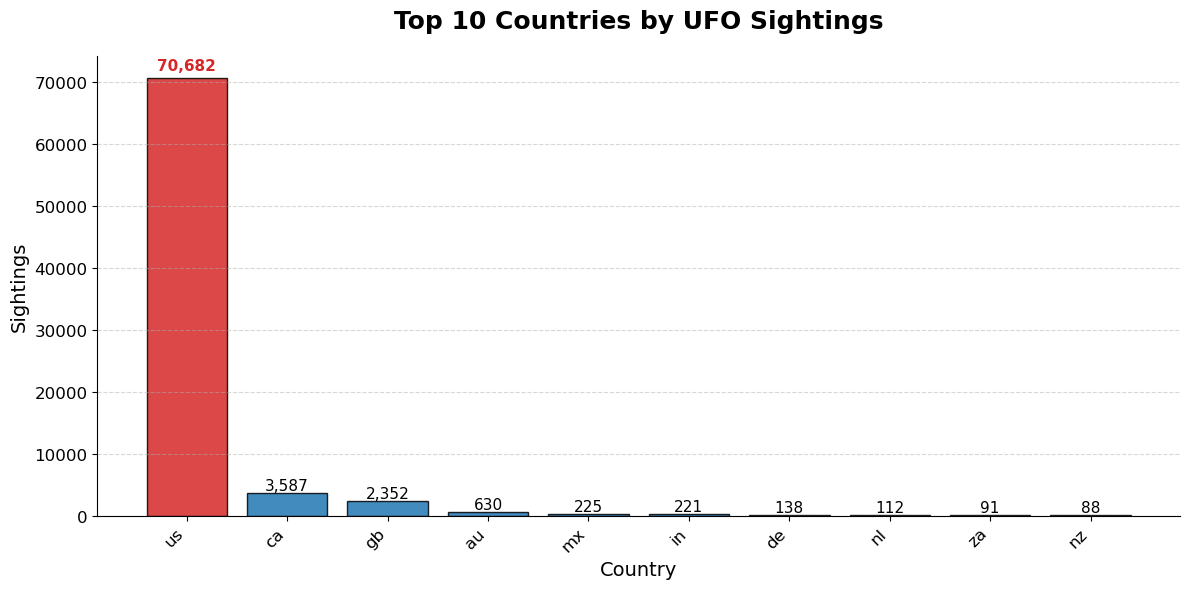

In [94]:
# Count sightings per country (using full names)
country_counts = df.groupby("country_final").size().sort_values(ascending=False)

# Select top 10 countries
top_10 = country_counts.head(10)

# Identify top country
top_country = top_10.idxmax()
top_value = top_10.max()

# Colors (highlight top)
colors = ["#1f77b4" if c != top_country else "#d62728" for c in top_10.index]

plt.figure(figsize=(12, 6))

plt.bar(
    top_10.index,
    top_10.values,
    color=colors,
    edgecolor="black",
    alpha=0.85
)

# Annotate each bar
for i, val in enumerate(top_10.values):
    plt.text(
        i,
        val * 1.01,
        f"{val:,}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold" if top_10.index[i] == top_country else "normal",
        color="#d62728" if top_10.index[i] == top_country else "black"
    )

plt.title("Top 10 Countries by UFO Sightings", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Sightings", fontsize=14)

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


**Notes**:
- Compared to other countries, reports of UFO-sightings are largely concentrated in the U.S. (70,682). 
- Canada (3,587) and the United Kingdom (2,352) are the next highest reporters. However, even combined their reported sightings fall significantly below the U.S. 
- The remaining countries in the top 10 (e.g., Australia, Mexico, India, Germany, Netherlands, South Africa, New Zealand) all report fewer than 1,000 sightings, respectively.
- Differences across countries likely reflect reporting systems, cultural attitudes, media access, and data availability rather than true differences in UFO activity.
- These results represent reporting activity by country, not necessarily true underlying UFO frequency.

### 3.4 U.S.-Only: State-Level Sightings

Purpose: Reveal geographic variation in reported UFO sightings within the U.S. by identifying which states report the highest activity. 

#### 3.4.1 Chart Rationale & Visual Integrity

This visualization compares the top 15 U.S. states by reported UFO sightings using an ethically structured horizontal bar chart.

Key design decisions:

- A horizontal bar chart improves readability for long categorical labels (state abbreviations).
- The y-axis remains in descending order to emphasize proportional differences without misleading scale manipulation.
- Bars begin at zero to preserve proportional accuracy.
- The highest-reporting state (California) is highlighted with a contrasting color (#d62728) for emphasis without altering underlying values.
- Values are annotated directly on bars to increase transparency and reduce misinterpretation.
- The data shown represents raw counts, with no smoothing, scaling, or normalization applied.

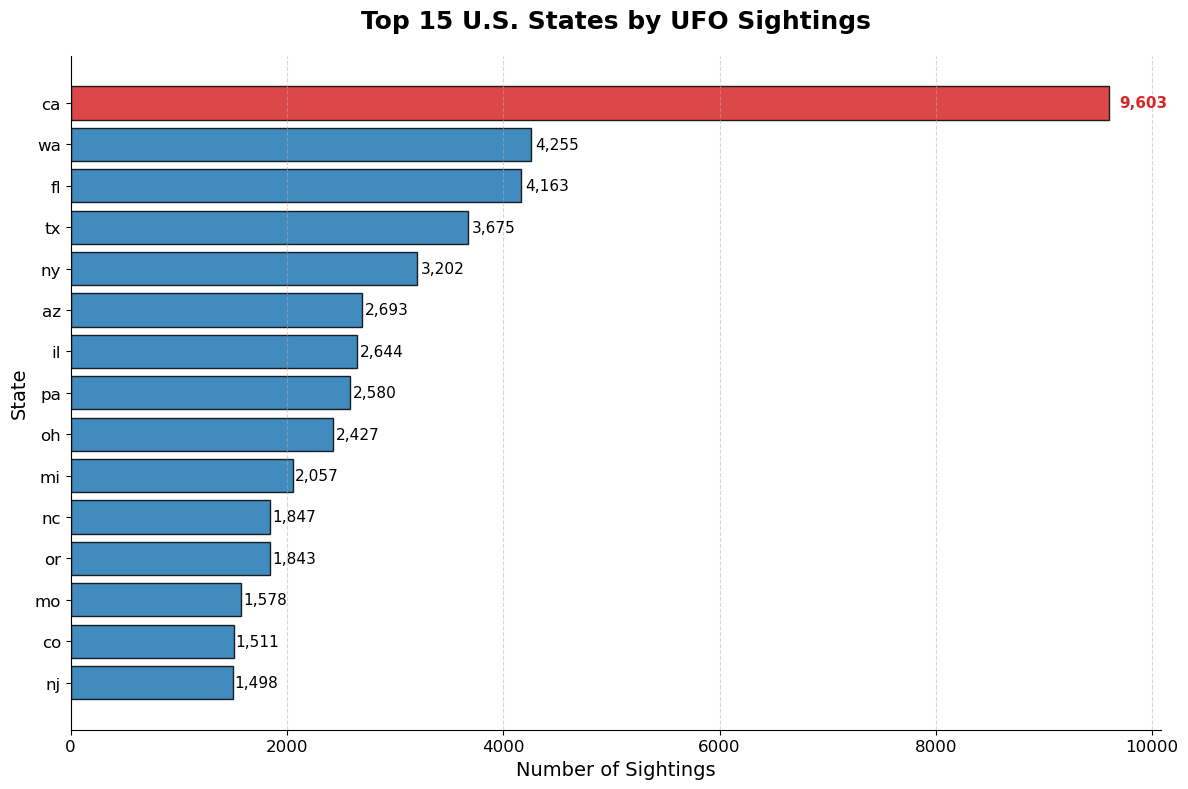

In [95]:
# Filter U.S.-only data
us_states = df[df["country_final"] == "us"]

# Count sightings per state and select top 15
state_counts = (
    us_states.groupby("state_final")
    .size()
    .sort_values(ascending=False)
    .head(15)
)

# Identify the top state
top_state = state_counts.idxmax()
top_value = state_counts.max()

# Colors: highlight the top state
colors = ["#1f77b4" if state != top_state else "#d62728" for state in state_counts.index]

# Create figure
plt.figure(figsize=(12, 8))

# Horizontal bar chart
plt.barh(
    state_counts.index[::-1],      # reverse index so highest appears at top
    state_counts.values[::-1],
    color=colors[::-1],            # reverse colors to match bars
    edgecolor="black",
    alpha=0.85
)

# Annotate each bar with value
for i, (state, value) in enumerate(zip(state_counts.index[::-1], state_counts.values[::-1])):
    plt.text(
        value + (value * 0.01),   # small offset
        i,
        f"{value:,}",
        va="center",
        fontsize=11,
        fontweight="bold" if state == top_state else "normal",
        color="#d62728" if state == top_state else "black"
    )

# Titles and labels
plt.title("Top 15 U.S. States by UFO Sightings", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Number of Sightings", fontsize=14)
plt.ylabel("State", fontsize=14)

# Remove top/right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Tick label formatting
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid
plt.grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


**Notes**
- California reports the largest number of sightings (9,603), followed by Washington (4,255) and Florida (4,163).
- All top-reporting states show totals above 2,000 sightings, while remaining states in the top 15 range from ~1,500–3,700.
- At the lower end of the full dataset, several U.S. territories and provinces appear with very small counts.
- These counts reflect reported sightings only, not true event frequency.
- Differences in counts may reflect population size, reporting behavior, media access, or cultural attitudes, and no causal conclusions can be drawn from this visualization alone.
- These results represent reporting activity within the U.S., not necessarily true underlying UFO frequency.

In [96]:
import us   # library for U.S. state name lookup

# Filter for U.S.-only dataset
us_df = df[df["country_final"] == "us"]

# Count sightings per state
state_counts = (
    us_df.groupby("state_final")
        .size()
        .sort_values(ascending=False)
        .reset_index(name="sightings")
)
# Add ful state names automatically
state_counts["state_name"] = state_counts["state_final"].apply(
    lambda abbr: us.states.lookup(abbr).name if us.states.lookup (abbr) else abbr
)

# Top  & Bottom states
top_10_states = state_counts.head(10)
bottom_10_states = state_counts.tail(10)

# Display
print("Top 10 U.S. States by UFO Sightings")
display(top_10_states)

print("Bottom 10 U.S. States by UFO Sightings")
display(bottom_10_states)

Top 10 U.S. States by UFO Sightings


state_final  sightings    state_name
0          ca       9603    California
1          wa       4255    Washington
2          fl       4163       Florida
3          tx       3675         Texas
4          ny       3202      New York
5          az       2693       Arizona
6          il       2644      Illinois
7          pa       2580  Pennsylvania
8          oh       2427          Ohio
9          mi       2057      Michigan

Bottom 10 U.S. States by UFO Sightings


state_final  sightings   state_name
50          dc         96           dc
51          pr         26  Puerto Rico
52          bc          4           bc
53          ab          2           ab
54          nf          2           nf
55          on          2           on
56          pq          2           pq
57          ns          1           ns
58          sk          1           sk
59          qc          1           qc

**Notes**
- At the lower end of the distribution, several states and territories show fewer than 10 reported sightings, including Northwest Territories (1), Quebec (1), Nova Scotia (1), Prince Edward Island (2), and Nunavut (2).
- These counts reflect reports contained within the dataset only and may not represent true sighting frequency.
- Some of the lowest-count entries correspond to U.S. territories or Canadian provinces (e.g., PR, BC, QC), indicating mixed geographic classifications in the dataset.
- The contrast between the highest and lowest states highlights a long-tailed distribution, where a few states report very large numbers while many report very few.

### 3.5 Compare UFO Shapes (Original vs. Inferred Shape)

Purpose: Determine whether inferred UFO shape classifications differ meaningfully from originally reported shapes and visualize how frequently each shape appears in both fields.

#### 3.5.1 Why this Chart?

A grouped bar chart clearly compares frequency differences between categories and makes it easy to observe alignment or disagreement between original and inferred shape labels.

#### 3.5.2 Design & Integrity Decisions

- A consistent bar width and axis scale prevents visual exaggeration.
- Bars are ordered by original shape frequency, highlighting the most commonly reported shapes first.
- Labels are added directly above bars to avoid forcing the viewer to cross-reference the legend.
- Colors remain minimal and functional (blue = original, red = inferred) rather than decorative.
- Counts are raw; no normalization is used to preserve data integrity.

#### 3.5.3 Comparison of Original vs. Inferred UFO Shape Distribution

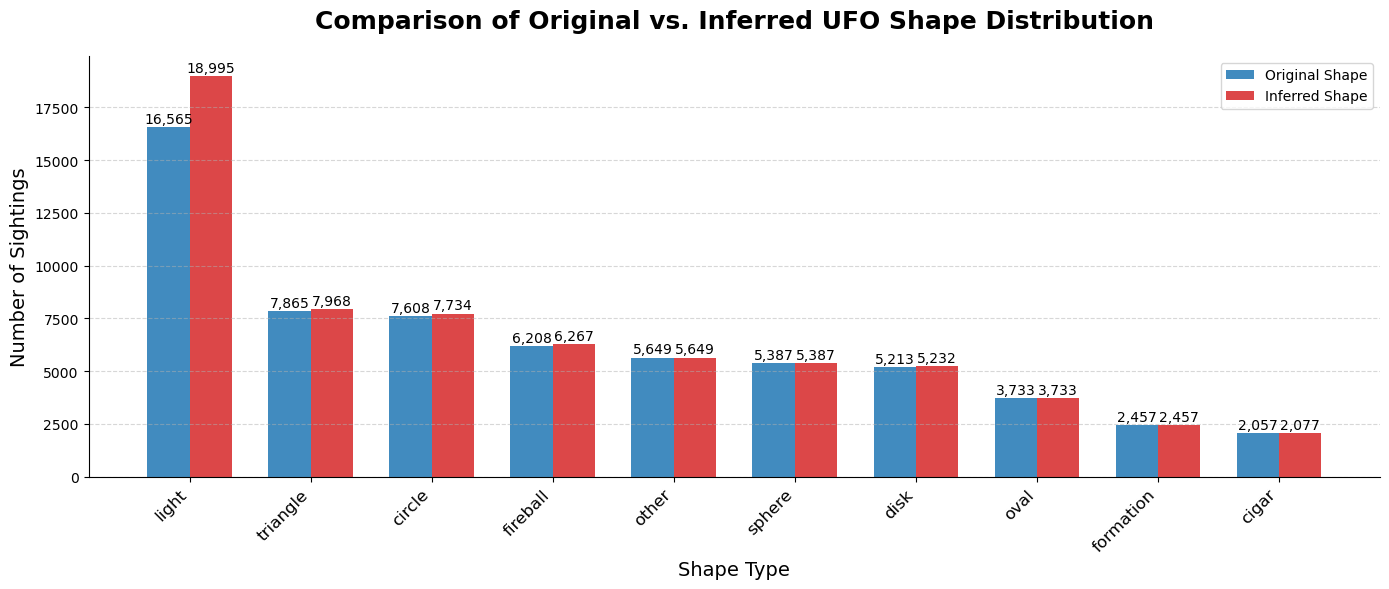

In [97]:
# Compute value counts for original and inferred shapes
orig_counts = df["shape"].value_counts()
inf_counts = df["shape_inferred"].value_counts()

# Combine into a single DataFrame aligned by shape name
shape_compare = pd.DataFrame({
    "Original": orig_counts,
    "Inferred": inf_counts
}).fillna(0).astype(int)

# Keep only top 10 most common shapes (based on Original counts)
shape_compare = shape_compare.sort_values("Original", ascending=False).head(10)

# Plot side-by-side bar chart
plt.figure(figsize=(14, 6))

x = np.arange(len(shape_compare))     # numerical positions
width = 0.35                          # bar width

# Bars
orig_bars = plt.bar(x - width/2, shape_compare["Original"], 
                    width, label="Original Shape", color="#1f77b4", alpha=0.85)

inf_bars = plt.bar(x + width/2, shape_compare["Inferred"], 
                   width, label="Inferred Shape", color="#d62728", alpha=0.85)

# ADD VALUE LABELS ON EACH BAR
for bar in orig_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, 
        f"{height:,}", ha='center', va='bottom', fontsize=10, color="black")

for bar in inf_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, 
        f"{height:,}", ha='center', va='bottom', fontsize=10, color="black")


# Labels & title
plt.title("Comparison of Original vs. Inferred UFO Shape Distribution",
          fontsize=18, fontweight="bold", pad=20)

plt.xlabel("Shape Type", fontsize=14)
plt.ylabel("Number of Sightings", fontsize=14)
plt.xticks(x, shape_compare.index, rotation=45, ha="right", fontsize=12)

plt.legend()

# Spines + grid
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

**Notes**
- “Light” is the most commonly reported UFO shape in both original and inferred classification fields.
- Several shapes show similar frequencies across original and inferred labels (e.g., triangle, circle, fireball), suggesting consistent categorization.
- A few shapes show modest divergence (e.g., light, sphere), where inferred counts slightly exceed original reports.
- Lower-frequency shapes (e.g., formation, cigar) show minor variation between classification methods.
- The distributions appear broadly comparable overall, indicating no extreme disagreements between the two classification systems.
- This visualization doesn't measure classification accuracy; it only shows how frequency distributions vary in this dataset.


### 3.6 Duration Distribution (Cleaned Data)

Purpose: To examine the statistical distribution of UFO sighting durations (in seconds) after removing invalid values and extreme outliers. This analysis establishes whether the cleaned duration field is suitable for later modeling tasks such as clustering or correlation analysis.

#### 3.6.1 Overview of Duration Values (Before cleaning)

Before performing any cleaning, it is important to understand how the raw duration values behave. Summary statistics reveal that the distribution is heavily right-skewed, suggesting the presence of extremely short and extremely long durations that may distort analysis and modeling.

In [98]:
df_trimmed["duration (seconds)"].describe()

count    79666.000000
mean       728.984058
std       1654.123322
min          0.001000
25%         30.000000
50%        180.000000
75%        600.000000
max      14400.000000
Name: duration (seconds), dtype: float64

#### 3.6.2 Histogram of Raw Duration Values

**Purpose of This Chart**

This chart explores how long UFO sightings typically last in their raw form and reveals whether most reports describe short or extended events.

**Why This Chart Type?**
- A histogram visualizes the distribution of a skewed metric clearly.
- It allows detection of long-tailed behavior and clusters.
- It exposes extreme values that may need removal for modeling integrity.

**Design & Integrity Notes**
- The y-axis begins at zero to avoid misrepresenting frequency.
- No smoothing or KDE curve is applied here to prevent implying continuity in raw values.
- Because raw durations are highly skewed, this visualization can be misleading without later cleaning or log-scaling.
- Titles and axis labels are included to ensure interpretability.

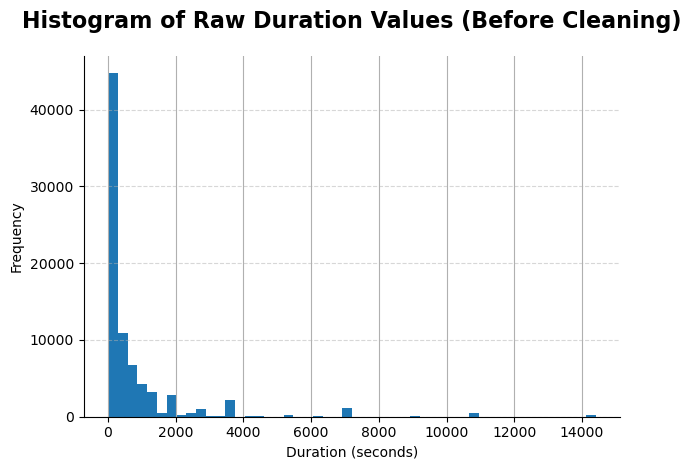

In [99]:
df_trimmed["duration (seconds)"].hist(bins=50)

plt.title("Histogram of Raw Duration Values (Before Cleaning)", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")

# Spines + grid
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

**Notes**
- The distribution of raw sighting durations is highly right-skewed, with the majority of events lasting only a few seconds.
- A small number of observations extend into extremely long durations (up to 14,400 seconds), confirming the presence of outliers.
- These extreme values may not represent genuine sightings and motivate later trimming and cleaning steps.
- The clustering of counts near the minimum suggests most reports are short-duration events.
- Because raw durations span several orders of magnitude, later visualizations will use log scaling for improved interpretability.

In [100]:
df_trimmed["duration (seconds)"].isna().sum()

np.int64(0)

In [101]:
df_trimmed["duration (seconds)"].sort_values().head(20)

4081     0.001
23754    0.010
42378    0.010
70587    0.010
56596    0.010
52996    0.010
70393    0.010
67354    0.020
13375    0.020
18735    0.050
42057    0.050
78381    0.050
2038     0.050
21258    0.050
7378     0.050
7262     0.080
13366    0.080
7920     0.100
18891    0.100
32487    0.100
Name: duration (seconds), dtype: float64

In [102]:
df_trimmed["duration (seconds)"].sort_values().tail(20)

51767    14400.0
51768    14400.0
51771    14400.0
22549    14400.0
15444    14400.0
74550    14400.0
35636    14400.0
68137    14400.0
68138    14400.0
35815    14400.0
26584    14400.0
79469    14400.0
35779    14400.0
6935     14400.0
67211    14400.0
9027     14400.0
58462    14400.0
71676    14400.0
11606    14400.0
15391    14400.0
Name: duration (seconds), dtype: float64

#### 3.6.3 Identifying Minimum and Maximum Duration Values

To determine appropriate cleaning thresholds, we inspect the smallest and largest values in the dataset. This step helps detect invalid entries (e.g., near-zero durations or multi-hour durations) that may represent recording errors rather than actual observations.

In [103]:
df_trimmed["duration (seconds)"].dtype
df_trimmed["duration (seconds)"].apply(type).unique()

array([<class 'float'>], dtype=object)

**Cleaning Rationale**
- Durations below 1 second likely represent instrument or entry errors.
- Durations above 7200 seconds (2 hours) are extremely rare and disproportionately distort distribution-based visualizations and modeling.
- Restricting the analysis to 1–7200 seconds preserves meaningful data while removing values that compromise visual integrity or statistical fairness.

In [104]:
# Extract duration columns
dur = df_trimmed["duration (seconds)"]

# Clean duration data: remove invalid tiny values + extreme outliers
clean_durations = dur[(dur >= 1) & (dur <= 7200)]   # 1 second to 2 hours

clean_durations.describe()

count    78688.000000
mean       607.289480
std       1175.820242
min          1.000000
25%         30.000000
50%        180.000000
75%        600.000000
max       7200.000000
Name: duration (seconds), dtype: float64

#### 3.6.4 Cleaning Duration Values

Purpose: To convert the duration field into a consistent numeric format and remove problematic values (e.g., non-numeric entries, NaNs, extreme outliers).

In [105]:
# Convert to numeric
df_trimmed["duration (seconds)"] = pd.to_numeric(df_trimmed["duration (seconds)"], errors="coerce")

# Drop null values created during conversion
df_trimmed = df_trimmed.dropna(subset=["duration (seconds)"]).copy()

C:\Users\nlnz8\AppData\Local\Temp\ipykernel_11604\517562420.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Note**: A *SettingWithCopyWarning* may appear because the column was edited on a sliced DataFrame. Using .copy() ensures operations are applied safely and prevents chained assignment errors.

#### 3.6.5 Short Sightings: 0-7200 seconds (3 minutes - 2 hours)

**Purpose of This Chart**
To visualize the cleaned distribution of UFO sighting durations and reveal whether typical sightings are brief or extended.

**Why This Chart Type?**
- A KDE curve highlights density patterns and long-tail behavior more clearly than a histogram alone.
- A log-scaled x-axis prevents short durations from being visually compressed.
- This combination best reflects the true shape of a heavily skewed distribution.

**Design & Integrity Notes**
- A log scale is used to avoid compressing the many short-duration sightings.
- Durations outside 1–7200 seconds were removed to avoid distortion.
- The KDE curve is labeled as "Density" rather than "Frequency" to avoid misinterpretation.
- Tick labels include both seconds and human-readable time units for accessibility.

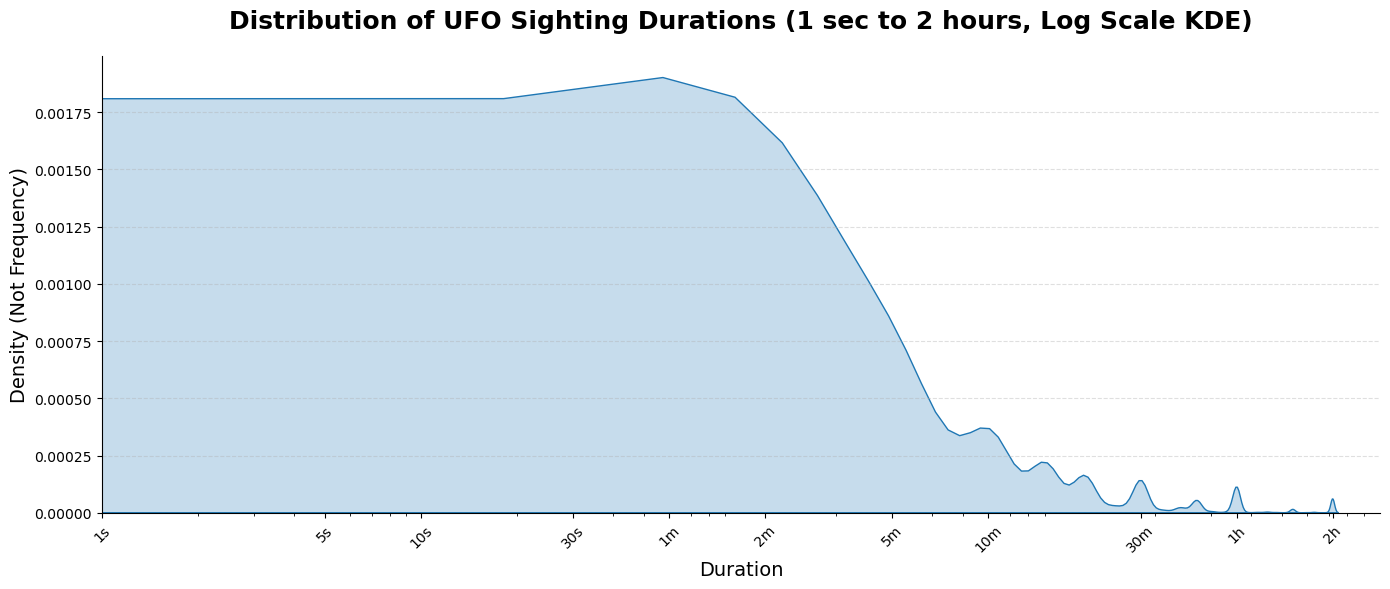

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter durations
dur = df_trimmed["duration (seconds)"]
dur = dur[(dur >= 1) & (dur <= 7200)]

plt.figure(figsize=(14, 6))

# KDE plot
sns.kdeplot(
    dur,
    fill=True,
    bw_adjust=0.8,
    color="#1f77b4"
)

# Log-scale x-axis
plt.xscale("log")

# Duration ticks
ticks = [1, 5, 10, 30, 60, 120, 300, 600, 1800, 3600, 7200]
labels = ["1s", "5s", "10s", "30s", "1m", "2m", "5m", "10m", "30m", "1h", "2h"]
plt.xticks(ticks, labels, rotation=45)

# Titles & labels
plt.title("Distribution of UFO Sighting Durations (1 sec to 2 hours, Log Scale KDE)", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Duration", fontsize=14)
plt.ylabel("Density (Not Frequency)", fontsize=14)

# Spines & grid
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

**Notes**
- The cleaned duration values span 1 to 7200 seconds (1 second to 2 hours), ensuring removal of implausible or distorted entries.
- The distribution is strongly right-skewed, with most sightings lasting under 10 minutes.
- The median duration is 180 seconds (3 minutes).
- Density in the KDE plot peaks between roughly 10 and 300 seconds, indicating that brief sightings are the most common.
- Durations longer than 1500 seconds represent only a very small fraction of all reports.
- The KDE chart uses a log-scaled x-axis to prevent shorter durations from being visually compressed and to improve readability of the long-tailed distribution.
- The y-axis shows probability density, not raw counts. 
- A tall peak doesn't mean thousands of sightings.
- It simply shows where sighting durations are more common compared with the rest of the dataset.
- The total area under the curve is 1, so the chart highlights the shape of the distribution, not the number of reports.

### 3.7 Duration vs. Shape 

Purpose: To compare the sighting duration distributions across the top 10 most commonly reported UFO shapes.
This helps identify whether some shapes tend to have longer or shorter reported durations.
This section uses descriptive statistics only and does not infer causality or behavioral traits.

**Purpose of This Chart**: 

This visualization shows whether certain shapes are associated with unusually long or short reported durations.

**Why This Chart Type? (Boxplot)**

A boxplot is appropriate because:
- It summarizes each shape’s distribution (median, IQR, range).
- It reveals outliers without letting extreme values dominate.
- It allows shape-to-shape comparison at a glance.
- Using a log scale prevents long-duration sightings from compressing short-duration distributions.

**Design and Integrity Notes**
- Only cleaned durations (1–7200 seconds) are used.
- A log-scaled y-axis improves interpretability of the long-tailed distribution.
- Outliers are hidden only for display readability; they were not removed from the analysis.
- Median duration values are annotated directly on each box to improve clarity.

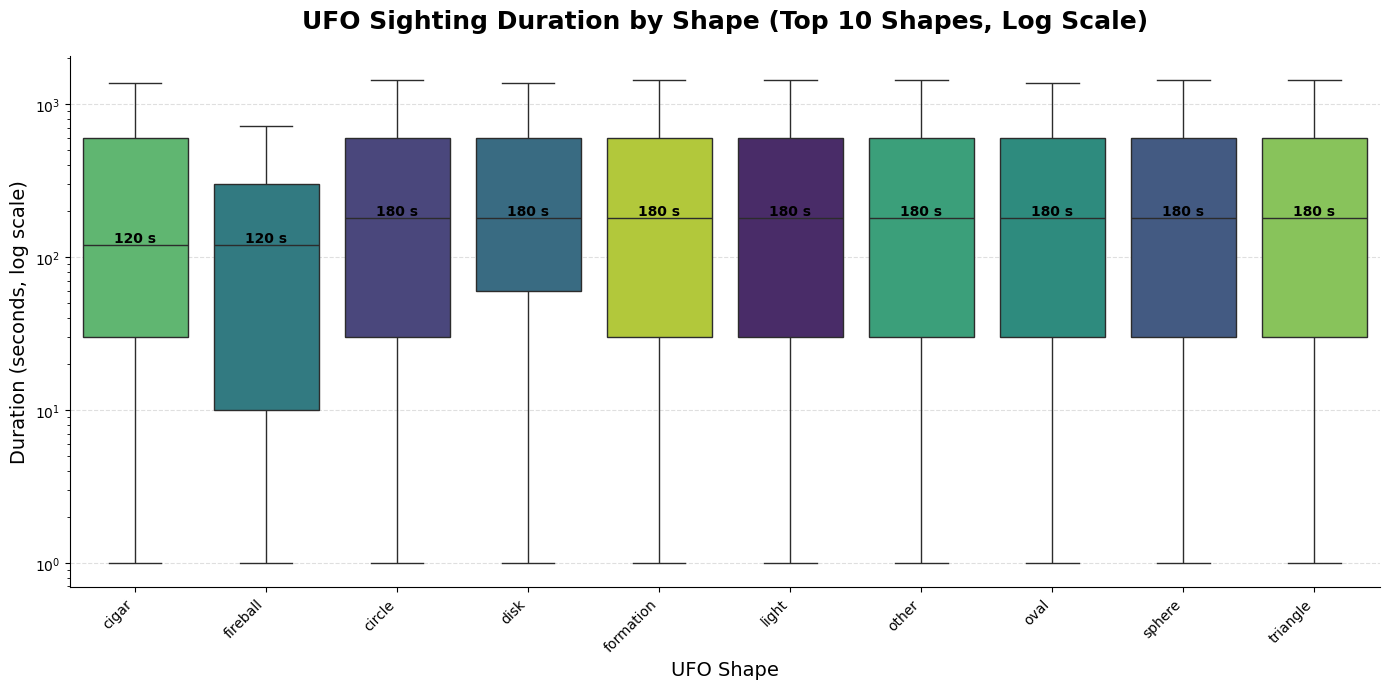

In [107]:
# Use cleaned durations (1-7200 seconds)
df_shape = df_trimmed[
    (df_trimmed["duration (seconds)"] >= 1) &
    (df_trimmed["duration (seconds)"] <= 7200) 
].copy()

# Get Top 10 most common UFO shapes reported
top10_shapes = (
    df_shape["shape"]
    .value_counts()
    .head(10)
    .index
)

df_top10 = df_shape[df_shape["shape"].isin(top10_shapes)]

# Sort shapes by median duration
shape_order = (
df_top10.groupby("shape")["duration (seconds)"]
    .median()
    .sort_values()
    .index
)

# Create the boxplot
plt.figure(figsize=(14, 7))

sns.boxplot(
    data=df_top10,
    x="shape",
    y="duration (seconds)",
    order=shape_order,
    hue="shape",
    dodge=False,
    showfliers=False,   # outliers removed for readability
    palette="viridis"
)

plt.yscale("log")
plt.xticks(rotation=45, ha="right")

# Titles & labels
plt.title(
    "UFO Sighting Duration by Shape (Top 10 Shapes, Log Scale)",
    fontsize=18,
    fontweight="bold",
    pad=20
)
plt.xlabel("UFO Shape", fontsize=14)
plt.ylabel("Duration (seconds, log scale)", fontsize=14)

# Annotate each box with its median
medians = df_top10.groupby("shape")["duration (seconds)"].median()

ax = plt.gca()

for i, shape in enumerate(shape_order):
    median_val = medians[shape]
    ax.text(
        i, median_val,
        f"{int(median_val)} s",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="black"
    )

# Remove top & right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Grid styling
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

**Notes**
- The top 10 UFO shapes show substantial overlap, meaning shapes do not differ strongly in sighting duration.
- Most shapes have a median duration between 2–3 minutes (≈180 seconds).
- “Cigar” and “fireball” shapes tend toward slightly shorter durations (~120 seconds).
- “Circle,” “formation,” “light,” “oval,” “sphere,” and “triangle” shapes tend toward ~180 seconds.
- Displaying the chart on a log scale prevents shorter durations from being visually compressed.
- Overall, shape does not appear to meaningfully influence sighting duration in this cleaned dataset.

### 3.8 Geographic Scatterplot (Latitude vs. Longitude)

Purpose: To visualize where reported UFO sightings occur across the globe using geographic coordinates.
This section identifies regions of dense reporting and provides an initial understanding of spatial clustering.

#### 3.8.1 Global Map (Point Heatmap)

The following features a global scatterplot where each point corresponds to a reported UFO sighting that includes valid latitude and longitude values.

**Purpose of This Chart**:

This map highlights global clustering of reported sightings using a raw-point representation.

**Why This Chart Type?**

A scatterplot:
- Shows unbiased raw spatial distribution.
- Works well with large datasets.
- Reveals clusters without imposing boundaries or artificial groupings.

**Design and Integrity Notes**
- Transparency prevents dense clusters (e.g., U.S., Western Europe) from hiding individual points.
- Latitude/longitude values were validated before plotting to ensure accuracy.
- The map reflects reported sightings, not true frequency or actual extraterrestrial activity.
- Regions with fewer points may reflect lower reporting, not fewer events.

In [108]:
import plotly.express as px
import pandas as pd

# Extract and clean latitude/longitude
geo = df_trimmed.copy()

# Clean coordinates
geo = geo[
    (geo["latitude"].between(-90, 90)) & 
    (geo["longitude"].between(-180, 180))
]

fig = px.scatter_geo(
    geo, 
    lat="latitude",
    lon="longitude",
    opacity=0.3,
    size_max=3,
    projection="natural earth"
)

fig.update_layout(
    title="Global UFO Sightings (Plotly Map)",
    title_x=0.5
)

fig.show()

**Notes**:
- Most recorded sightings with valid coordinates occur in the United States, Western Europe, and Australia.
- Africa, Central Asia, and parts of South America appear sparse largely due to low reporting infrastructure, not necessarily a lack of sightings.
- The dataset is Western-centric, which must be considered when interpreting global patterns.
- Thicker clusters in the U.S. occur because the dataset includes 70,000+ U.S. reports, far more than any other region.

#### 3.8.2 Top 10 Global Cities with the Highest Reported UFO-Sightings

Purpose: To identify, for each of the ten (10) countries with the most sightings, the single city reporting the highest number of sightings.

*Method Summary*:
1. Identify top 10 countries by total sightings.
2. Filter dataset to only those countries.
3. Group by city + country to count sightings.
4. Select the highest-reporting city in each of the 10 countries.
5. Display results in a table and bar plot.

In [109]:
# Top 10 countries with most UFO sightings
top10_countries = (
    df_trimmed.groupby("country_final")
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Filter only records from these top 10 countries
df_top_countries = df_trimmed[df_trimmed["country_final"].isin(top10_countries)]

# For each country, find the single city with the highest sighting count
top_city_per_country = (
    df_top_countries.groupby(["country_final", "city"])
    .size()
    .reset_index(name="sighting_count")
)

# Select only the top city per country
top_city_per_country = (
    top_city_per_country
    .sort_values(["country_final", "sighting_count"], ascending=[True, False])
    .groupby("country_final")
    .head(1)           # take top city for each country
    .sort_values("sighting_count", ascending=False)
    .reset_index(drop=True)
)

top_city_per_country

country_final                           city  sighting_count
0            us                        seattle             524
1            gb            london (uk/england)             189
2            ca               toronto (canada)             172
3            au  melbourne (vic&#44 australia)              39
4            nz         auckland (new zealand)              30
5            mx                cancun (mexico)              22
6            in              bangalore (india)              20
7            za       cape town (south africa)              13
8            de               berlin (germany)              11
9            nl        rotterdam (netherlands)               7

#### 3.8.3 Top 10 Global Cities with the Highest Reported UFO-Sightings

**Why This Chart Type?**:
- A bar chart makes cross-country comparison intuitive.
- Labels placed outside bars avoid clutter and meet readability standards.
- Country-color encoding reinforces geographic grouping.

**Design and Integrity Notes**
- City names were not standardized beyond dataset values; spelling variants may reflect reporting inconsistencies.
- The bars represent unadjusted counts, showing the total number of reported sightings without accounting for population size.
- This visualization does not imply any causal or behavioral mechanism.

In [110]:
import plotly.express as px

fig = px.bar(
    top_city_per_country,
    x="city",
    y="sighting_count",
    color="country_final",
    title="<b>Top 10 Global Cities with the Highest Reported UFO Sightings</b>",
    labels={
        "city": "City",
        "sighting_count": "Number of Sightings",
        "country_final": "Country"
    },
    text="sighting_count",
)

fig.update_traces(textposition="outside")

fig.update_layout(
    xaxis_tickangle=45,
    title_x=0.5,
    showlegend=True,
    bargap=0.2
)

fig.show()


**Notes**:
- Seattle (United States) has the highest count among the top 10 countries (524 sightings).
- London (UK) and Toronto (Canada) follow with 189 and 172 sightings.
- Most non-US cities report fewer than 50 sightings, illustrating the dataset’s strong U.S. reporting bias.
- Australia and New Zealand show single-digit or low-tens counts per top city, reflecting scale differences in national reporting.

#### 3.8.3 Global Density Heatmap (KDE on a Real Map)

**What This Heatmap Represents**
- This visualization applies a kernel density estimation (KDE) to highlight where UFO sightings are most spatially concentrated.
- Brighter colors indicate regions with higher relative concentration of reported sightings, not absolute counts.

**Purpose of This Chart**

This chart provides a smoothed density view of global UFO sightings, revealing broad spatial clusters rather than focusing on individual points. It supports large-scale spatial interpretation across tens of thousands of reported sightings.

**Why This Chart Type?**
- A KDE heatmap generalizes point clusters into broader, continuous regions of density.\
- This method is useful for large datasets because it reveals overall spatial patterns more effectively than point scatterplots alone.
- KDE reduces visual noise and highlights global "hotspots" in reporting behavior.

**Design and Integrity Notes**
- A perceptually uniform color scale is used to avoid overstating intensity differences.
- KDE bandwidth was selected to avoid generating misleading artificial “hotspots” in sparsely populated regions.
- A neutral basemap ensures density information remains visually dominant.
- KDE represents smoothed concentration, not true event frequency; density values do not correspond to actual counts.

#### 3.8.4 Global UFO Sightings Density (Heatmap)

In [111]:
fig = px.density_map(
    geo,
    lat="latitude",
    lon="longitude",
    radius=7,
    center=dict(lat=20, lon=0),
    zoom=0.7,
    map_style="carto-positron"
)

fig.update_layout(
    title="Global UFO Sightings Density (Heatmap)",
    title_x=0.5
)

fig.show()


**Notes**:
- Highest-density regions appear in the continental United States and Western Europe, consistent with earlier geographic plots.
- The United States exhibits the highest density, attributable to a substantial reporting volume exceeding 70,000 sightings.
- Western Europe, especially the United Kingdom and Germany, shows moderate density clusters.
- Australia exhibits notable but smaller clusters compared to the U.S. and Europe.
- Regions such as Africa, central Asia, most of South America, and Antarctica show low density, likely reflecting sparse reporting rather than absence of phenomena.
- KDE density does not indicate absolute frequency; it visualizes reporting concentration, not the number of sightings.

#### 3.8.5 U.S.-Only Map (States Outlines + Points)

In [112]:
# Download GeoJSON file

import json
import urllib.request

url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
urllib.request.urlretrieve(url, "us_states.geojson")


('us_states.geojson', <http.client.HTTPMessage at 0x2171d373a10>)

**Notes**
- The GeoJSON file provides the geographic boundary shapes for all U.S. states.
- Plotly uses these boundaries to draw accurate state outlines beneath the sighting points.

**Purpose of This Chart**

This visualization isolates U.S.-specific UFO sightings to examine domestic spatial patterns and compare them with earlier national-level findings.

**Why This Chart Type?**
- A state-outline scatterplot retains geographic structure while allowing fine-grained inspection of clusters across the United States.
- Plotting individual points preserves detail without imposing assumptions about regional boundaries.

**Design and Integrity Notes**
- A GeoJSON boundary file ensures accurate state outlines beneath the plotted points.
- Latitude/longitude filtering removes invalid coordinates prior to mapping.
- Points are displayed with transparency to prevent overplotting in dense regions.
- This visualization reflects reported sightings only and should not be interpreted as true UFO activity or prevalence.

#### 3.8.6 U.S. UFO Sightings (Locations)

In [113]:
with open("us_states.geojson") as f:
    staes = json.load(f)

usa = geo[
    (geo["latitude"].between(24, 50)) &
    (geo["longitude"].between(-125, -66))
]

fig = px.scatter_geo(
    usa,
    lat="latitude",
    lon="longitude",
    scope="usa",
    opacity=0.3
)

fig.update_geos(fitbounds="locations")
fig.update_layout(
    title="U.S. UFO Sightings",
    title_x=0.5
)

fig.show()

**Notes**
- Sightings are widespread across the U.S., with major concentrations along the West Coast, Pacific Northwest, Midwest, and Northeast.
- Strong clustering appears around California and Washington, matching earlier state-level rankings.
- Sparse regions include the Rocky Mountains and rural central states, possibly due to lower population density or fewer reports.
- The visualization reinforces the earlier finding that U.S. reports dominate the dataset in both volume and spatial richness.

#### 3.8.7 Top 10 U.S. Cities with the Highest Reported UFO Sightings

Purpose: To identify the ten U.S. cities with the highest number of reported UFO sightings and to compare their relative reporting volumes.

**Method Summary**
- Identify the top 10 U.S. cities by total sighting count.
- Filter the dataset to U.S.-based records.
- Group by both city and state to ensure geographic accuracy.
- Display results in both tabular and bar-chart formats.

**Why This Chart Type?**
- A bar chart clearly communicates ranking and relative magnitude.
- Displaying the data table alongside the chart allows verification and cross-checking.
- Sorting by sighting count ensures visual integrity and prevents misinterpretation.

**Design and Integrity Notes**
- Cities are sorted explicitly by descending sighting count to preserve clarity.
- Numerical labels ensure transparency in reporting volume.
- Bars are color-coded by state to avoid ambiguity in multi-state city names.

In [114]:
# Top 10 U.S. Cities with the highest reported UFO sightings 
top_10_us_cities = (
    df_trimmed[df_trimmed["country_final"] == "us"]
    .groupby(["city", "state_final"])
    .size()
    .reset_index(name="sighting_count")
    .sort_values(by="sighting_count", ascending=False)
    .head(10)
)

top_10_us_cities

city state_final  sighting_count
15457      seattle          wa             523
13447      phoenix          az             446
9251     las vegas          nv             361
9847   los angeles          ca             350
15065    san diego          ca             334
13880     portland          or             329
7760       houston          tx             294
3066       chicago          il             263
17369       tucson          az             239
10804        miami          fl             229

In [115]:
import plotly.express as px

# Sort by sighting_count descending
top_10_us_cities = top_10_us_cities.sort_values("sighting_count", ascending=False)
fig = px.bar(
    top_10_us_cities,
    x="city",
    y="sighting_count",
    color="state_final",
    text="sighting_count",
    title="<b>Top 10 U.S. Cities with the Highest Reported UFO Sightings</b>",
    labels={
        "city": "City",
        "sighting_count": "Number of Sightings",
        "state_final": "State"
    },
    category_orders={"city": top_10_us_cities["city"].tolist()}     # enforce sorted order
)

fig.update_traces(textposition="outside")

fig.update_layout(
    xaxis_tickangle=45,
    title_x=0.5,
    bargap=0.2,
    showlegend=True
)

fig.show()

**Notes**:
- Seattle, Washington leads with 523 reported sightings, consistent with global city-level results.
- Phoenix (AZ) and Las Vegas (NV) follow with 446 and 361 sightings respectively.
- Large metropolitan areas such as Los Angeles (334) and Chicago (263) appear in the top ten but do not lead the rankings.
- Many of the highest-reporting cities are located in Western states (AZ, NV, CA, WA), matching earlier geographic clustering.
- The distribution indicates a long--tailed pattern, with several cities reporting high counts while others taper rapidly.
- These rankings reflect reporting volume, not true event frequency, and may be influenced by population size, local culture, and public reporting tendencies.

## 4. Environment and Reproducibility Notes

This notebook was originally developed inside a Python virtual environment (.venv).
Due to installation issues involving GeoPandas on Windows, the analysis environment was migrated to a conda environment named ufo.

### 4.1 Environment Setup

All required packages were installed using this environment:

1. conda create -n ufo python=3.11
2. conda activate ufo
3. conda install geopandas shapely pyproj rtree fiona -c conda-forge
4. pip install plotly pandas seaborn matplotlib

### 4.2 Reproducibility

- This notebook was executed in JupyterLab (VS Code) using the active ufo conda environment.
- All figures will reproduce identically as long as the same package versions are installed.
- Any platform-specific issues (e.g., GeoPandas on Windows) are resolved through the conda-forge installation route.
- The notebook contains no hidden state; rerunning all cells from top to bottom will reproduce all results.

## 5. Final Insights Summary 

This exploratory analysis reveals several clear patterns in global and U.S. UFO sighting behavior:
1. Geographic reporting is heavily concentrated in a few regions
- The U.S. reports dramatically more sightings than any other country (≈70,000+ of the ~88,000 total records).
- Western Europe, especially the U.K. and Germany, shows moderate reporting levels.
- Africa, Central Asia, and South America appear sparse primarily due to lower reporting infrastructure, not necessarily fewer sightings.

2. Short sightings dominate the dataset
- Most sightings last under 10 minutes.
- The median sighting duration is ~180 seconds (3 minutes).
- The distribution is highly right-skewed, with a long tail of rare, long-duration events.

3. Reported shapes show interesting common trends
- The most frequently reported shapes are light, triangle, and circle.
- Duration distributions across shapes show substantial overlap, suggesting shape type does not strongly influence how long sightings last.
- “Cigar” and “fireball” shapes tend to have slightly shorter median durations (~120 seconds).

4. Significant clustering exists within the United States
- Washington, California, Arizona, and Florida show the highest concentrations of sightings.
- Seattle is the top U.S. city by volume (523 sightings), far above other cities in the nation.
- Western states show dense reporting clusters, while the Rocky Mountain region and rural central states show sparse reports.

5. Data patterns reflect reporting behavior more than true event frequency
- Population density, internet access, and cultural interest may influence reporting volume.
- Global KDE density maps highlight where people report sightings, not necessarily where UFO activity occurs.